In [1]:
import pickle
from PIL import Image
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

In [2]:
with open("./normal.pickle", "rb") as f:
    normal_hash = pickle.load(f)
    
with open("./normal_faces.pickle", "rb") as f:
    normal_faces = pickle.load(f)
    
alp_uv = loadmat("./UV_Processed.mat")

with open("./parts_list_ids.pickle", "rb") as f:
    parts_list_ids = pickle.load(f)
    
with open("./atlas_hash.pickle", "rb") as f:
    atlas_hash = pickle.load(f)
    
with open("normal2atlas_512_200.pickle", mode='rb') as f:
    mapping_relation = pickle.load(f)

In [3]:
normal_tex = transforms.ToTensor()(Image.open("./normal_texture.jpg"))
# normal_tex = no

In [4]:
normal_tex_batch = torch.stack([normal_tex, normal_tex])
normal_tex_batch = normal_tex_batch.transpose(1, -1)
normal_tex_batch.shape

torch.Size([2, 512, 512, 3])

In [5]:
c, h, w = normal_tex.shape

In [6]:
bs, h, w, c = normal_tex_batch.shape
print(bs, h, w, c)

2 512 512 3


In [7]:
atlas_size = 200

In [8]:
vertex_tex = {}

In [9]:
for k, v in normal_hash.items():
    vertex_tex[k] = normal_tex[:, int(h - v[0][1] * (h-1)), int(v[0][0] * (w - 1))]

In [10]:
FaceIndices = alp_uv["All_FaceIndices"].squeeze()
FacesDensePose = alp_uv["All_Faces"] - 1
U_norm = alp_uv["All_U_norm"].squeeze()
V_norm = alp_uv["All_V_norm"].squeeze()
All_vertices = alp_uv["All_vertices"][0]

In [11]:
# parts_list_ids = {}
# for parts_num in range(1, 25):
#     FaceIndicesNow = np.where(FaceIndices == parts_num)
#     FacesNow = FacesDensePose[FaceIndicesNow]
#     parts_list_id = np.unique(FacesNow.flatten())
#     parts_list_ids[parts_num] = parts_list_id
# with open("./parts_list_ids.pickle", "wb") as f:
#     pickle.dump(parts_list_ids, f)

In [12]:
# atlas_hash = {}
# for parts_num in range(1, 25):
#     parts_list_id = parts_list_ids[parts_num]
#     for u, v, ver in zip(
#         list(U_norm[parts_list_id]),
#         list(V_norm[parts_list_id]),
#         list(All_vertices[parts_list_id])):
#         if (ver - 1) in atlas_hash:
#             atlas_hash[ver - 1].append([parts_num, u, v])
#         else:
#             atlas_hash[ver - 1] = [[parts_num, u, v]]
# with open("./atlas_hash.pickle", "wb") as f:
#     pickle.dump(atlas_hash, f)

In [13]:
def mapping_to_each_atlas_parts(vertex_tex, parts_num):
    """
    Function to convert normal texture into each part of atlas texture.
    params:
    vertex_tex: Stores the texture for each point of the SMPL model.
    parts_num: The number of the parts. 1 ~ 24.
    """
    tex = torch.zeros((c, atlas_size, atlas_size))

    for k, v in atlas_hash.items():
        for t in v:
            if  t [ 0 ] ==  parts_num :
                tex[:, int(t[1] * (atlas_size - 1)), (atlas_size - 1) -
                    int(t[2] * (atlas_size - 1))] = vertex_tex[k]

    return tex / 255

In [14]:
atlas_texture = torch.zeros((24, c, atlas_size, atlas_size))
for  i  in  range ( 24 ):
    atlas_texture[i] = mapping_to_each_atlas_parts(vertex_tex, parts_num=i + 1)

In [15]:
atlas_texture.shape

torch.Size([24, 3, 200, 200])

In [16]:
mapping_relation[500000]

[66, 69, 3, 461, 443]

In [17]:
normal_tex_batch.shape

torch.Size([2, 512, 512, 3])

In [18]:
painted_atlas_tex = atlas_texture.clone()
# painted_atlas_tex = painted_atlas_tex.transpose(0, 1)
# for relation in mapping_relation:
#     new_tex = normal_tex_batch[:, :, relation[3], relation[4]]
#     painted_atlas_tex[:,relation[2], :, relation[0], relation[1]]
for relation in mapping_relation:
    new_tex = normal_tex[:, relation[3], relation[4]]
    painted_atlas_tex[relation[2], :, relation[0], relation[1]]  = new_tex / 255

In [19]:
painted_atlas_tex.shape

torch.Size([24, 3, 200, 200])

In [20]:
painted_atlas_permuted = painted_atlas_tex.permute(0, 2, 3, 1)
painted_atlas_permuted.shape

torch.Size([24, 200, 200, 3])

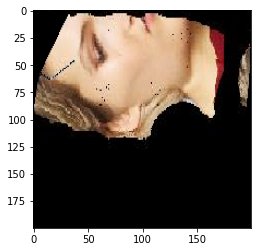

In [21]:
plt.imshow(painted_atlas_permuted[23].numpy() * 255)

In [22]:
np.unique(painted_atlas_permuted[23].numpy() * 255)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019